<a href="https://colab.research.google.com/github/rkarmaka/SAM-using-Python-for-Microscopy-Image/blob/main/Segment_Anything_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything in Python

**Objective:** *Write the objective of the course*

# Chapter 1: Introduction to SAM


## **Introduction:**

Segment Anything Model (SAM) is a foundation model [1] developed by Meta AI and introduced in the paper Segment Anything [2]. In this paper, authors have introduced a vision transformer based foundation model for zero-shot segmentation tasks. One of the main powerful feature of the model is that it is promptable using boxes, points, masks or texts. SAM was trained with 1 billion masks from 11 million images. Significant testing showed that SAM performs better than a lot of fully supervised model and fine tuning SAM with specific tasks can lead to even more accurate results. Since the publication in April 2023, multiple different papers have been published in different fields such as medical imaging [3], and biological imaging [4, 5] that uses SAM as a base model to segment their specific images.


## **Model Architecture:**

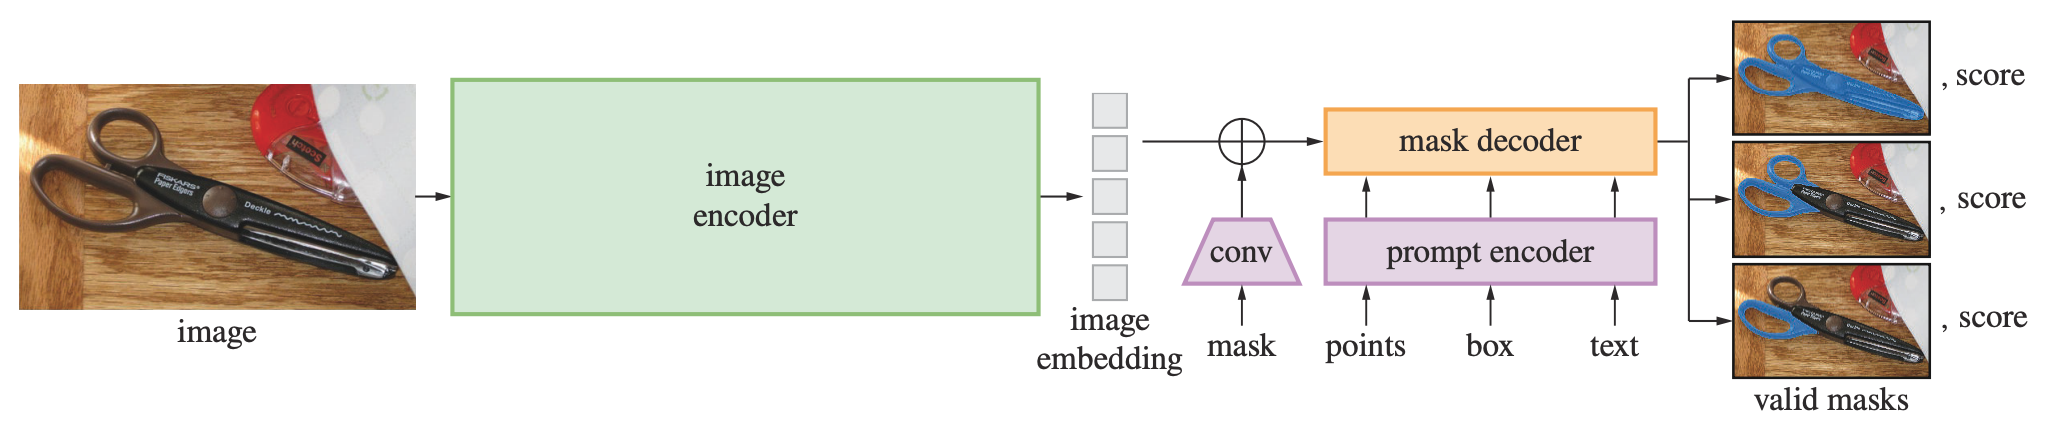

_(Source: Segment Anything [2])_

Above is the model architecture of SAM. It has three main building blocks: **image encoder**, **prompt encoder**, and **mask decoder**.

**Image encoder:** This block uses Vision Transformer (ViT) [6], pre-trained with Masked Autoencoder (MAE) [7] to create the image embedding. While this is the most time and resource consuming operation, it is run only once per image.

**Prompt encoder:** This block uses two sets of prompts: sparse promts in the form of points, boxes and text, and dense prompts in the form of masks. Points and boxes are encoded using positional encodings [8], combined with unique learned embeddings for each type of sparse prompt. Free-form text is processed using a standard text encoder from CLIP [9]. For dense prompts, convolutional methods are used to embed them, and these embeddings are then integrated with the image embedding through element-wise summation.

**Mask decoder:** The mask decoder effectively transforms the image embedding, prompt embeddings, and an output token into a mask through a modified Transformer decoder block [10], followed by a dynamic mask prediction mechanism.

## **Model Checkpoints:**

In the beginning, SAM was trained with public, annotated datasets. As more annotations were created using SAM, new annotations were used to retrain SAM. Three model versions with different backbone sizes were made available which are ViT-B, ViT-L, and ViT-H where ViT-B is the base model and ViT-H is the biggest model. Model size significantly increased from ViT-B to ViTH, so did the model's performance. However, ablation sstudy showed that the performance increase between ViT-L and ViT-H is minimal as showed in the figure below. Hence, based on a given task, using the model ViT-L might just be sufficient.

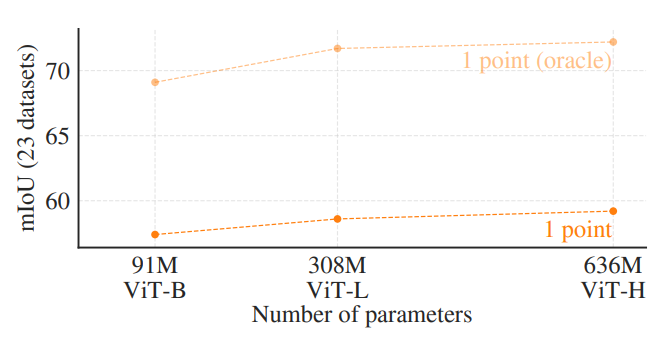
\
\
Model checkpoints can be downloaded from [here](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints).

# Chapter 2: Setting up SAM in Google Colab


Before we get started, it is important to setup your colab notebook. Hence, we will run some steps to select GPU, and install SAM and related packages. As Colab comes pre-installed with PyTorch, we do not need to install Torch. However, if you are running SAM on your local computer or on a high performance computing (HPC) cluster, we may need to run a few extra steps to setup your environment for SAM.

## Chapter 2.1: Setup and installations

### Step 1: Change Runtime type



Go to _Runtime_ > _Change runtime type_ > _Select_ **T4 GPU** and hit Save



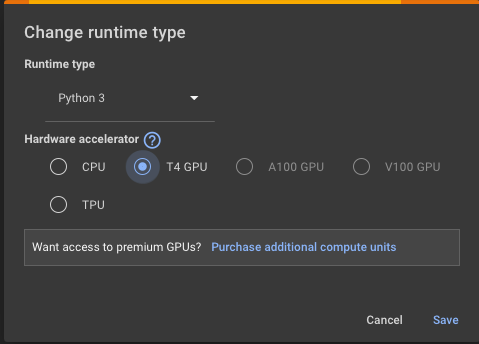

### Step 2: Mount Google Drive


For effective data management and model storage, integrating Google Drive is highly recommended. This approach offers a stable and permanent storage solution, unlike the temporary file storage in your workspace. Temporary storage is erased each time the runtime resets, leading to data loss. By establishing a directory system in Google Drive and mounting it, you can seamlessly access and manipulate data directly via Google Drive. Here’s how you can mount Google Drive:


**Using the Graphical User Interface (GUI):**
1. Locate the left-side panel in your workspace.
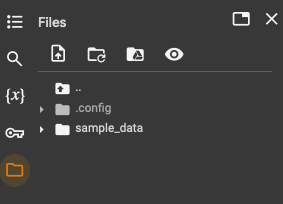
2. Click on the Google Drive icon Screenshot 2024-01-12 at 1.51.47 PM.png to initiate the mounting process.
3. A permission request will pop up. Click on _Connect to Google Drive_ to proceed.
Note: You might be prompted to log into your Google account. If you have multiple Gmail accounts, ensure you select the one associated with your Google Colab account.


After you click on it, it would ask you for your permission. Please allow by clicking on _Connect to Google Drive_. It may ask you to sign in to your google account. If you are logged into multiple gmail accounts, please make sure you select the account that you used to login to Google colab.



**Using code:**

Alternatively, you can mount Google Drive by executing the following two lines of code in your workspace. The authorization process remains the same as the GUI method.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Step 3: Install necessary packages


In this part of the course, we will install all the necessary packages for our project. First, we will install SAM, which is essential for the operations we will be performing. Along with SAM, we need [OpenCV](https://opencv.org/), a powerful library used for loading and manipulating images. For visual display purposes, we will also install [Matplotlib](https://matplotlib.org/), which is great for creating visualizations in Python. Lastly, we will add [Tifffile](https://pypi.org/project/tifffile/) to our setup, as it is specifically designed for reading .tif files. By installing these packages, you'll have all the required tools for effective image handling and visualization in our upcoming tasks.

As we are using Google Colab, we do not need to install [PyTorch](https://pytorch.org/) libraries, however, if you are running it locally, you may need to install necessary packages depending on the hardware you have available. You can check more information on how to install PyTorch [here](https://pytorch.org/get-started/locally/).

In [ ]:
# Install SAM
import sys
!{sys.executable} -m pip install opencv-python matplotlib tifffile
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

### _(Optional)_ Create directory structure and load images


In this part of the course, we'll organize a directory structure in our Google Drive and download images from our GitHub repository. This step is optional; you're welcome to use a different directory structure and your own images if you prefer. However, for the purposes of this tutorial, we will proceed with the assumption that the images are located in the directory **_/content/drive/MyDrive/SAMWorkshop/images_**. If you choose a different structure or images, you may need to adjust some of the instructions accordingly.

In [ ]:
# Create directory structure
!mkdir '/content/drive/MyDrive/SAMWorkshop'
!mkdir '/content/drive/MyDrive/SAMWorkshop/images'
!mkdir '/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints'
!mkdir '/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints/SAM'

# Download images
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/1.jpg
!wget -P '/content/drive/MyDrive/SAMWorkshop/images' https://raw.githubusercontent.com/rkarmaka/SAM-using-Python-for-Microscopy-Image/main/images/1.tif

## Chapter 2.2: Download model checkpoints and import necessary libraries

### Step 1: Download model checkpoint

Before we begin our practical work, it's essential to set up our environment. This involves downloading and loading a model checkpoint. In this example, we'll start with the default mode, 'vit_h', as our model of choice. However, feel free to explore other available model checkpoint. If you have developed your own model checkpoint, you're encouraged to use it in this exercise to see how it performs.

In [ ]:
!wget -P '/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints/SAM' https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

### Step 2: Import libraries

In [ ]:
# Import libraries
import torch
import torchvision
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tifffile import imread

# Chapter 3: Segment Everything with SAM

## Chapter 3.1: Segment all the objects in an image

In [ ]:
# Load an image
image_path = '/content/drive/MyDrive/SAMWorkshop/images'
image_name = '1.jpg'
image = cv.imread(f'{image_path}/{image_name}')

As we now loaded the image, let us first display the image and also create a function that we can call to display the image in the future.

In [ ]:
# Functtion to display an image
def display_image(image):
  fig, ax = plt.subplots(figsize=(10,10))
  ax.imshow(image, cmap='gray')
  ax.axis('off')

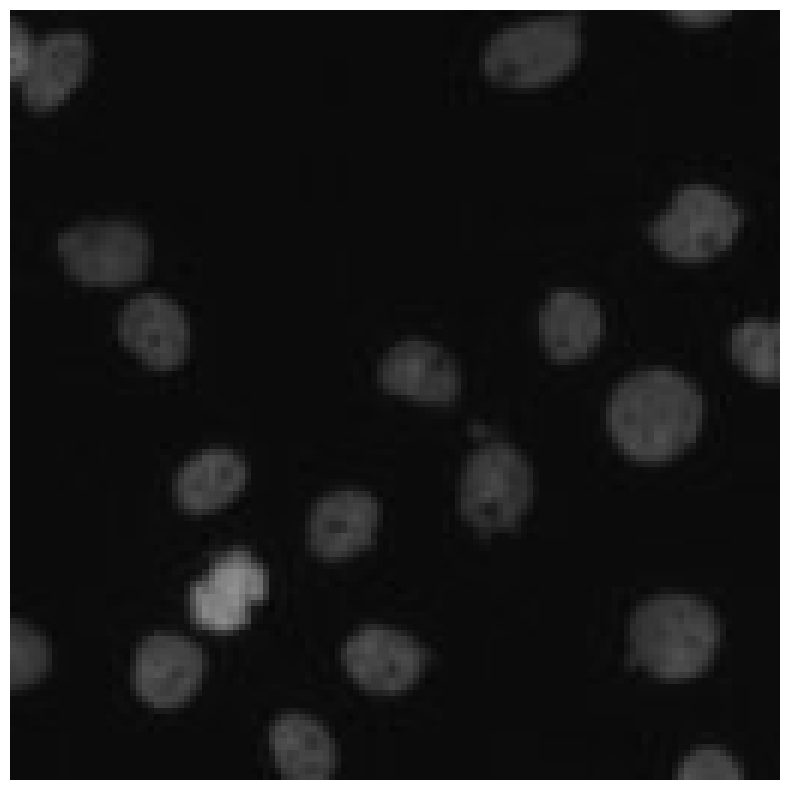

In [ ]:
display_image(image)

In this module, we will dive into a hands-on experience with the SAM. We'll explore how to load the model into our working memory, and utilize it for segmenting each object of interest within an image. This will also include an overview of various input parameters that you can adjust to tailor the segmentation process.

In this module, we will use SAM in its default settings to see how it identifies each object present in the image and segments them. We will also investigate the output to see what information we can extract from it.

In [ ]:
# Import SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

The step below is where SAM is loaded into the memory hence depending on the speed and memory capacity, this may take a moment.

In [ ]:
# Load SAM model
sam_checkpoint = "/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.cuda.is_available():
  device = "cuda"
  print("Using GPU")
else:
  device = "cpu"
  print("Using CPU")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

Using GPU


Let us first start with the default settings. Later we will see what input parameters we can change improve the segmentation result.

In [ ]:
# Generate mask
masks = mask_generator.generate(image)

Now as it created `masks`, let us investigate what outputs do we get:

**Q. What datastructure is `masks`?**

In [ ]:
type(masks)

list

**Q. What is the length of masks?**

In [ ]:
len(masks)

28

So, SAM detected 28 objects in the image.

**Q. What data structure is individual items inside `masks`?**

In [ ]:
type(masks[0])

dict

**Q. What are the keys of each dictionar?**

In [ ]:
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

So `masks`, the output of the generator function is a list of dictionaries where each dictionary contains a mask for each object it detected and segmented inside the image.

`segmentation`: Binary segmentation mask. \
`area`: his is the total number of pixels within the segmentation mask. It gives us a quantifiable size of the area covered by the mask. \
`bbox`: The bounding box is a rectangular box that frames the boundaries of the mask. It is defined in XYWH format, where 'X' and 'Y' represent the coordinates of the box's top-left corner, and 'W' and 'H' specify the width and height of the box, respectively. \
`predicted_iou`: This is the model's prediction of the mask's accuracy. It measures the overlap between the predicted mask and the actual area it's supposed to cover. A higher IOU indicates a more accurate mask. \
`point_coords`: These are the coordinates of the specific point that was used to generate the mask. It's the starting point from which the mask was developed. \
`stability_score`: This is an additional metric to assess the quality of the mask. It evaluates how consistent and reliable the mask is across various conditions or inputs. \
`crop_box`: This is the section of the original image that was used to generate the mask. Like the bounding box, it's defined in XYWH format and specifies the area of interest from which the mask was created. \

Now let us use `bbox` to draw bounding box around detected objects.

In [ ]:
# Display segmentation using bounding box
print(masks[2]['bbox']) #(x,y,w,h)

[8, 34, 15, 11]


You can change the value of `i` to look at different objects and draw bounding box around it

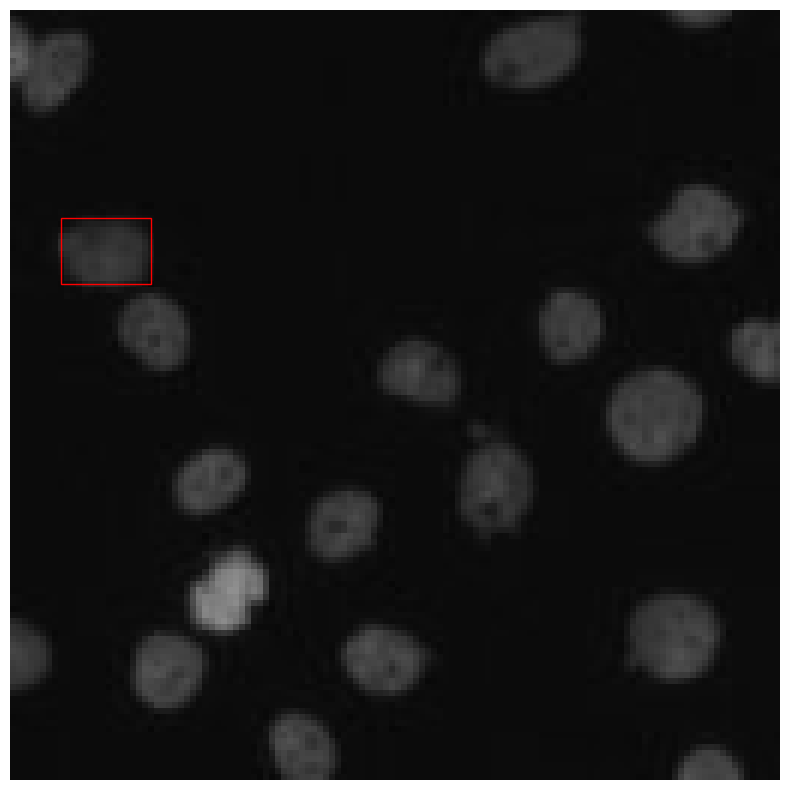

In [ ]:
i=2

# Create a figure and axes object.
fig, ax = plt.subplots(figsize=(10,10))

# Add the image to the axes object.
ax.imshow(image)
ax.axis('off')

x,y,w,h = masks[i]['bbox']
ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False))

Similarly, now let us draw bounding box around multiple objects:

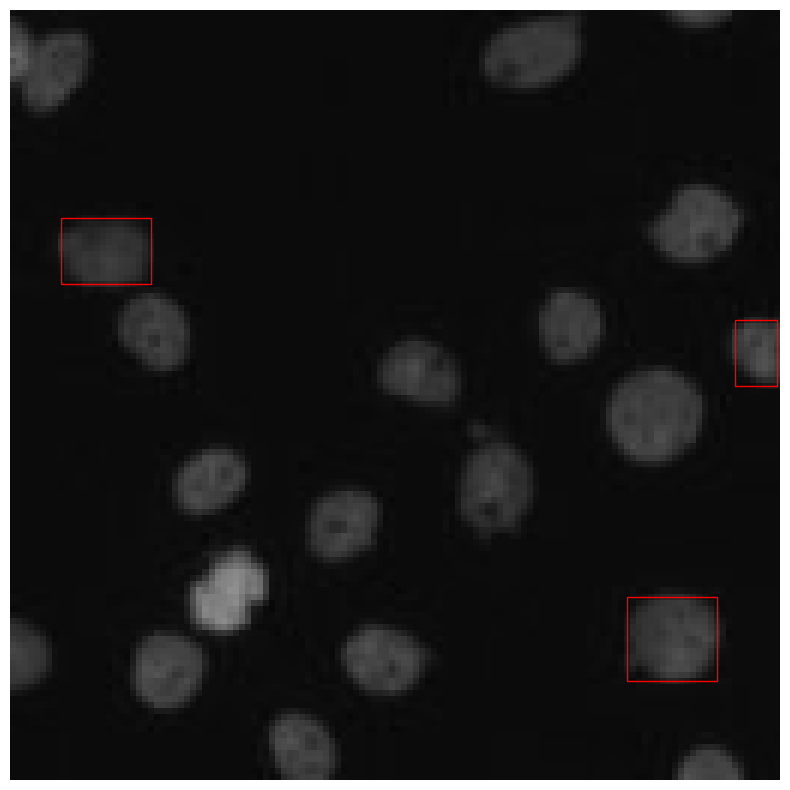

In [ ]:
items = [2,6,8]

# Create a figure and axes object.
fig, ax = plt.subplots(figsize=(10,10))

# Add the image to the axes object.
ax.imshow(image)
ax.axis('off')

for i in items:
  x,y,w,h = masks[i]['bbox']
  ax.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False))

With this, let us create a function that takes the image and the list of dictionaries as input and draws bounding boxes around all objects it found. This is going to be useful for future visualization tasks.

In [ ]:
# Display bounding boxes around all the objects detected
def display_image_with_bounding_boxes(image, masks):
  fig, ax = plt.subplots(figsize=(10,10))

  ax.imshow(image)
  ax.axis('off')

  for mask in masks:
    x,y,w,h = mask['bbox']
    ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))

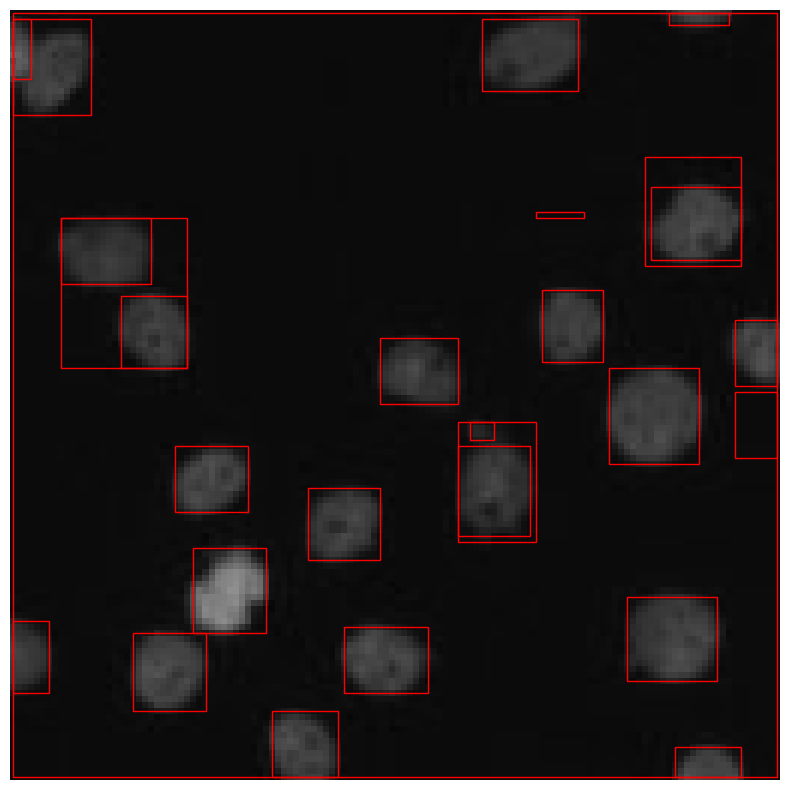

In [ ]:
display_image_with_bounding_boxes(image, masks)

## Chapter 3.2: Improve the results using input parameters

We noticed a couple of issues with the previoous segmentation result:
1. It is creating overlaping masks
2. It is detecting areas that are too small to be our region of interest

**Q. What input parameters do the automatic mask generator accept?**

**SamAutomaticMaskGenerator()** method has the following input arguments: \
`model`: The SAM model \
`points_per_side`: Number of points sampled along each side of the image, resulting in a total of (points_per_side)<sup>2</sup> points. If set to 'None', specify explicit point sampling in 'point_grids'. _(default: 32)_ \
`points_per_batch`: This parameter controls how many points the model processes at once. Increasing this number can speed up the process but will require more GPU memory. _(default: 64)_ \
`pred_iou_thresh`: Sets a threshold between 0 and 1 for filtering based on the predicted mask quality. _(default: 0.88)_ \
`stability_score_thresh`: Another filtering threshold, also between 0 and 1, focuses on the mask's stability under variations in the cutoff for binarizing mask predictions. _(default: 0.95)_ \
`stability_score_offset`: Adjusts the cutoff value used in calculating the stability score. _(default: 1.0)_ \
`box_nms_thresh`: Determines the cutoff for the Intersection over Union (IoU) in non-maximum suppression, which helps filter out duplicate masks. _(default: 0.7)_ \
`crop_n_layers`: If greater than 0, the mask prediction will be re-run on cropped sections of the image. The number of layers defines how many rounds of cropping occur, with each layer having an increasing number of image crops. _(default: 0)_ \
`crop_nms_thresh`: Similar to the box NMS threshold, this is used for filtering duplicates in different image crops. _(default: 0.7)_ \
`crop_overlap_ratio`: Defines the overlap between crops. In the initial layer, the crops overlap by this specified fraction of the image length, with the overlap decreasing in subsequent layers. _(default: 512 / 1500)_ \
`crop_n_points_downscale_factor`: The points-per-side sampled in each crop layer are scaled down by this factor. _(default: 1)_ \
`point_grids`: An optional list of explicit point grids for sampling, normalized to the range [0,1]. Each grid corresponds to a crop layer. This parameter is used instead of 'points_per_side'. _(default: None)_ \
`min_mask_region_area`: Sets a minimum area threshold for mask regions. Post-processing is applied to eliminate disconnected regions or holes in masks smaller than this area. Requires OpenCV. _(default: 0)_ \
`output_mode`: Choose how masks are returned. Options include 'binary_mask', 'uncompressed_rle', or 'coco_rle'. Note: 'coco_rle' requires pycocotools, and 'binary_mask' may consume significant memory at large resolutions. _(default: "binary_mask")_ \

**Q. Is there an input parameters that can be changed to remove overlapping masks?**

Yes, `box_nms_thresh`. Lower value of `box_nms_threshold` will result in less overlapping segments and higher value of `box_nms_threshold` will result in higher overlapping segments.

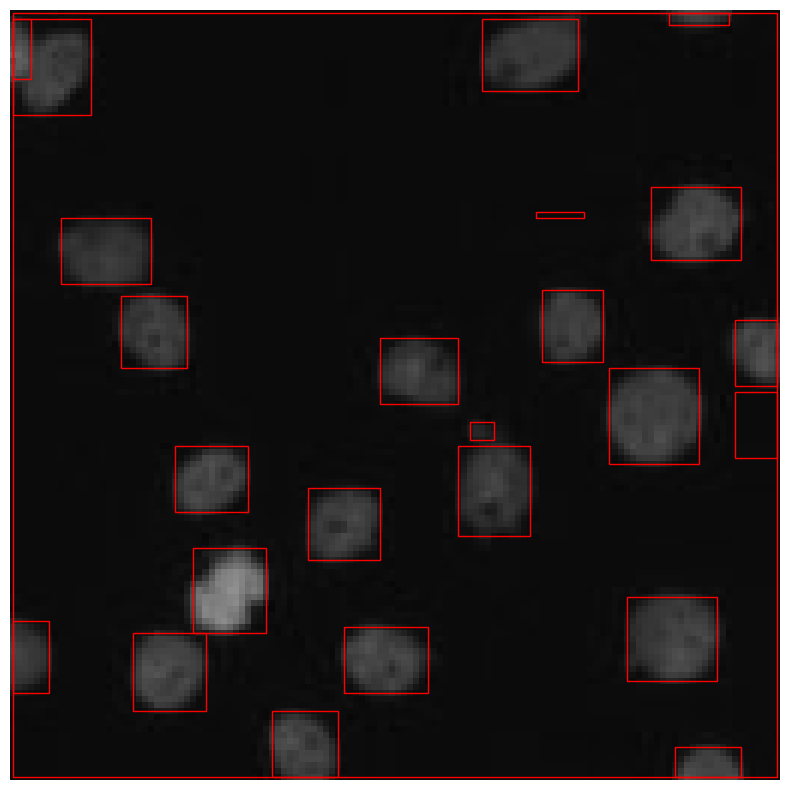

In [ ]:
# Generate masks with lower box_nms_thresh value
mask_generator_box_threshold = SamAutomaticMaskGenerator(sam, box_nms_thresh=0.3)
masks_box_threshold = mask_generator_box_threshold.generate(image)
display_image_with_bounding_boxes(image, masks_box_threshold)

Lowering the value of `box_nms_threshold` removed all the overlapping segmentations.

**Q. How many objects did it detect now?**

In [ ]:
len(masks_box_threshold)

25

The overlapping segmentaiton improved significantly. Now we can also filter by low area.

In [ ]:
# Print all the values of area
areas = [mask['area'] for mask in masks]
print(areas)

[16341, 222, 161, 137, 156, 111, 202, 116, 81, 57, 117, 143, 159, 133, 132, 175, 143, 164, 74, 133, 303, 29, 32, 200, 93, 277, 16, 17]


First item is a clear outlier and it is the whole image. If we remove that and plot the rest of the areas, we will get a good idea of the distribution. In most cases, we know the size of our object of interest. That apriori information along with the distribution, can be used to determine the range within which the object of interest lies. If the size of the object is unknown, the distribution can still be used to remove any outliers and filter the mask by area.

(array([4., 1., 3., 3., 8., 3., 2., 1., 0., 2.]),
 array([ 16. ,  44.7,  73.4, 102.1, 130.8, 159.5, 188.2, 216.9, 245.6,
        274.3, 303. ]),
 <BarContainer object of 10 artists>)

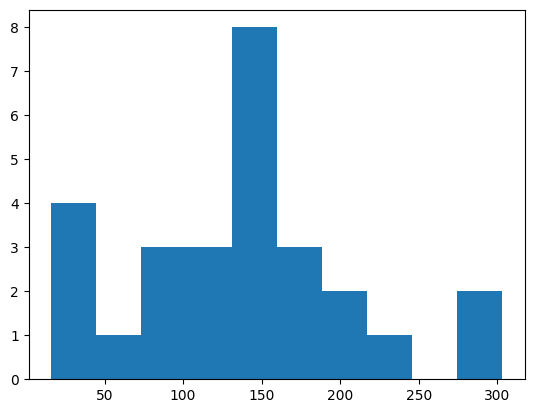

In [ ]:
# Plot areas
plt.hist(areas[1:])

Looks like anything between 100 and 250 is a good estimate.

Now let us modify the previous display function to accept minimum and maximum area thresholds and filter the outputs accordingly.

In [ ]:
# Display bounding box around all objects filtered by area
def display_image_with_bounding_boxes_area_filtered(image, masks, min_area=None, max_area=None):
  fig, ax = plt.subplots(figsize=(10,10))

  ax.imshow(image)
  ax.axis('off')

  if min_area is not None and max_area is not None:
    for mask in masks:
      if mask['area'] > min_area and mask['area'] < max_area:
        x,y,w,h = mask['bbox']
        ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))

  elif min_area is not None and max_area is None:
    for mask in masks:
      if mask['area'] > min_area:
        x,y,w,h = mask['bbox']
        ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))

  elif min_area is None and max_area is not None:
    for mask in masks:
      if mask['area'] < max_area:
        x,y,w,h = mask['bbox']
        ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))

  else:
    for mask in masks:
      x,y,w,h = mask['bbox']
      ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))

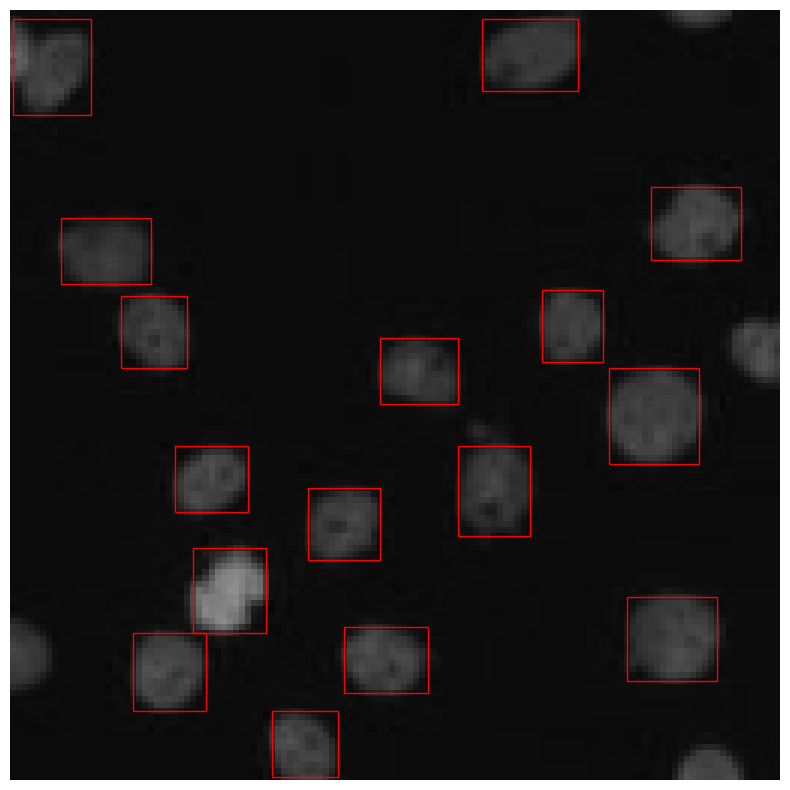

In [ ]:
display_image_with_bounding_boxes_area_filtered(image, masks_box_threshold, min_area=100, max_area=250)

**Q. How many objects do we have in the segmentation now?**

In [ ]:
len(masks_box_threshold)

25

The number did not change because while we filtered the results, we did not store the results anywhere. Hence, we will now rewrite the previous function to return the IDs of each object so that we can reference each object and work with filtered segmentation.

In [ ]:
# Display bounding box around all objects filtered by area and return object numbers
def display_image_with_bounding_boxes_area_filtered_return_object_number(image, masks, min_area=None, max_area=None):
  items = []
  fig, ax = plt.subplots(figsize=(10,10))

  ax.imshow(image)
  ax.axis('off')

  if min_area is not None and max_area is not None:
    for i, mask in enumerate(masks):
      if mask['area'] > min_area and mask['area'] < max_area:
        x,y,w,h = mask['bbox']
        ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))
        items.append(i)

  elif min_area is not None and max_area is None:
    for i, mask in enumerate(masks):
      if mask['area'] > min_area:
        x,y,w,h = mask['bbox']
        ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))
        items.append(i)

  elif min_area is None and max_area is not None:
    for i, mask in enumerate(masks):
      if mask['area'] < max_area:
        x,y,w,h = mask['bbox']
        ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))
        items.append(i)

  else:
    for i, mask in enumerate(masks):
      x,y,w,h = mask['bbox']
      ax.add_patch(plt.Rectangle((x,y), w, h, color='red', fill=False))
      items.append(i)

  return items

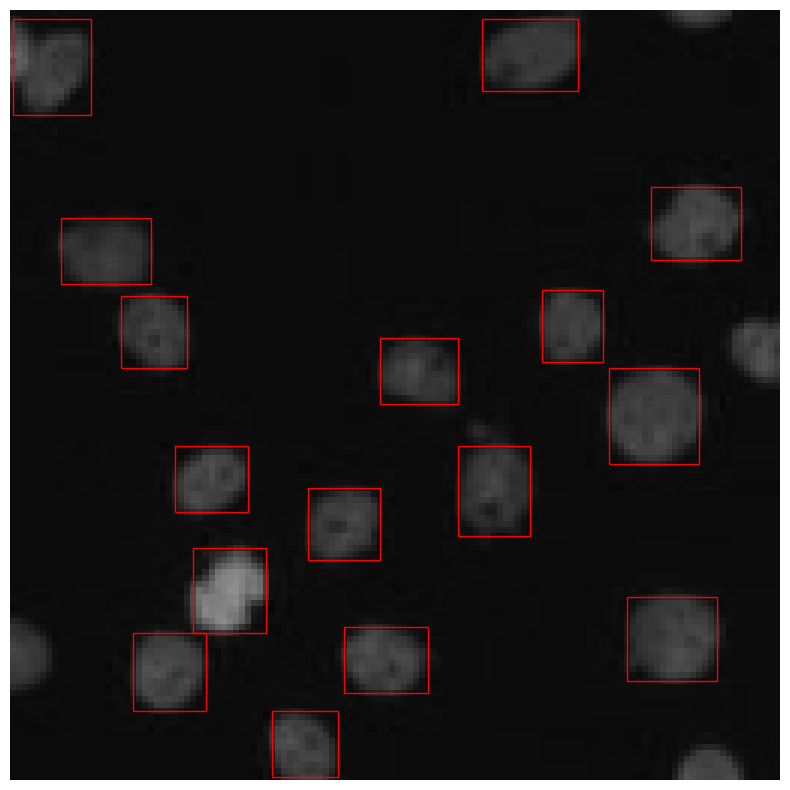

In [ ]:
items = display_image_with_bounding_boxes_area_filtered_return_object_number(image, masks_box_threshold, min_area=100, max_area=250)

**Q: What is the length of ```items```?



In [ ]:
len(items)

16

## Chapter 3.3: Displaying Segment Masks - Instances

We can now look at individual instances using the key ```segmentation```

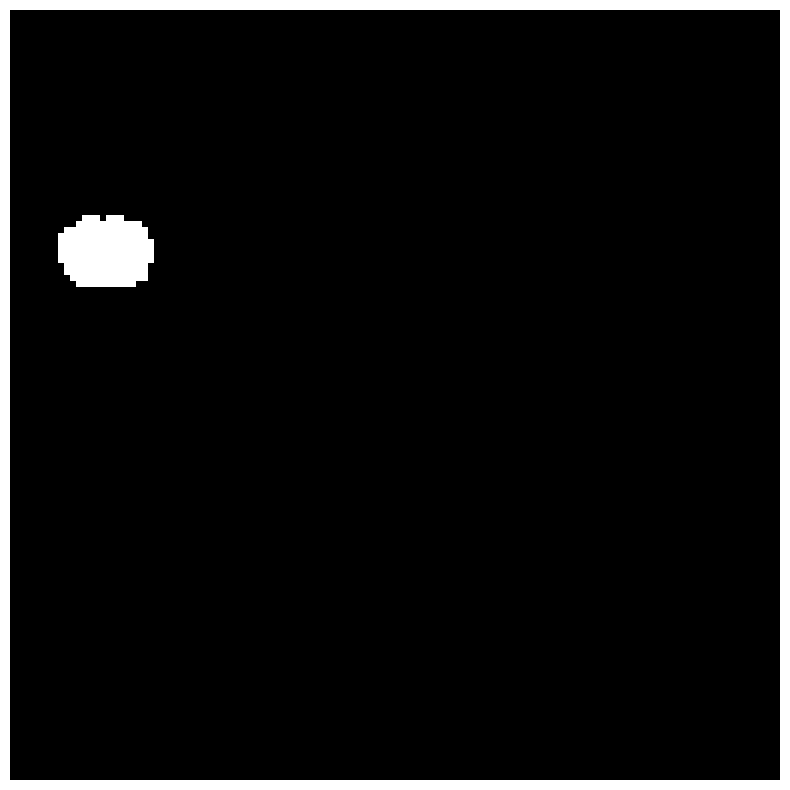

In [ ]:
display_image(masks[2]['segmentation'])

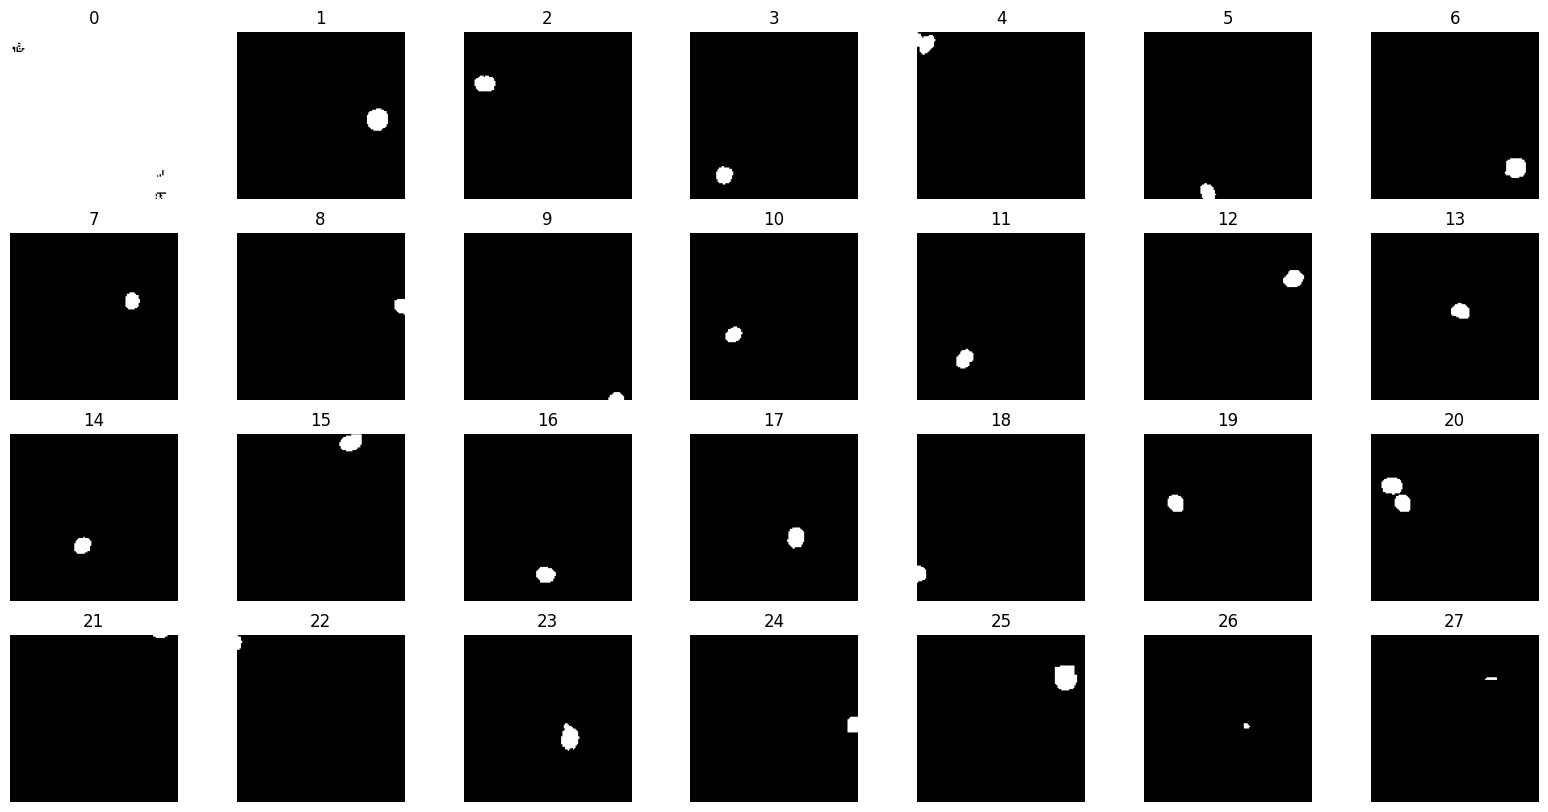

In [ ]:
plt.figure(figsize=(20,10))
for i, mask in enumerate(masks):
  plt.subplot(4,7,i+1)
  plt.imshow(mask['segmentation'], cmap='gray')
  plt.axis('off')
  plt.title(i)

For visualization, we will not draw outline around each object.

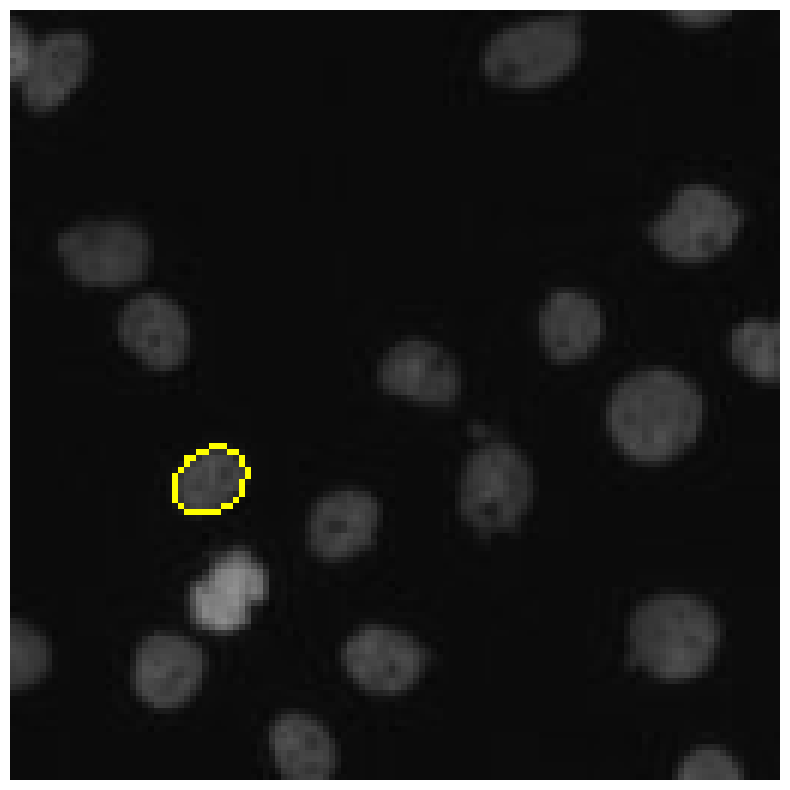

In [ ]:
# Draw outline around object i
img = np.copy(image)

i = 10
contours, _ = cv.findContours(masks_box_threshold[i]['segmentation'].astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img, contours, -1, color=[255, 255, 0], thickness=1)
display_image(img)

Similarly, let us create a function that does the same for all the objects.

In [ ]:
def display_image_with_overlay(image, masks, items=None, color=[255, 255, 0], thickness=1):
  img = np.copy(image)

  if items is None:
    for mask in masks:
      contours, _ = cv.findContours(mask['segmentation'].astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
      cv.drawContours(img, contours, -1, color=color, thickness=thickness)

  else:
    for i in items:
      contours, _ = cv.findContours(masks[i]['segmentation'].astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
      cv.drawContours(img, contours, -1, color=color, thickness=thickness)


  display_image(img)

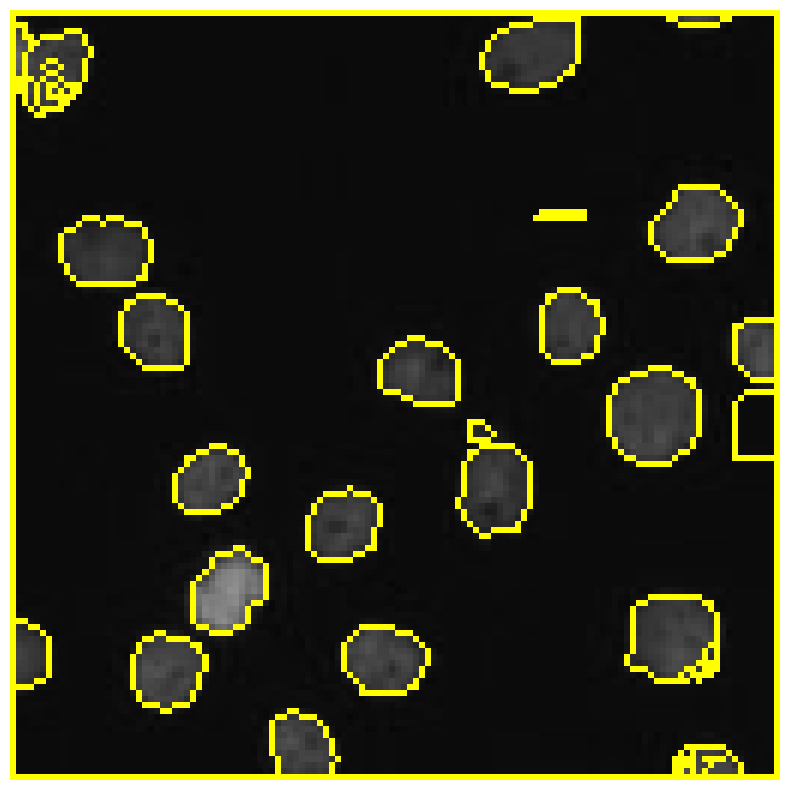

In [ ]:
display_image_with_overlay(image, masks_box_threshold)

Hold on! It is drawing outlines around all the objects, not the filtered objects. Let us use the list ```items``` to draw outlines around specific objects and display the filtered result.

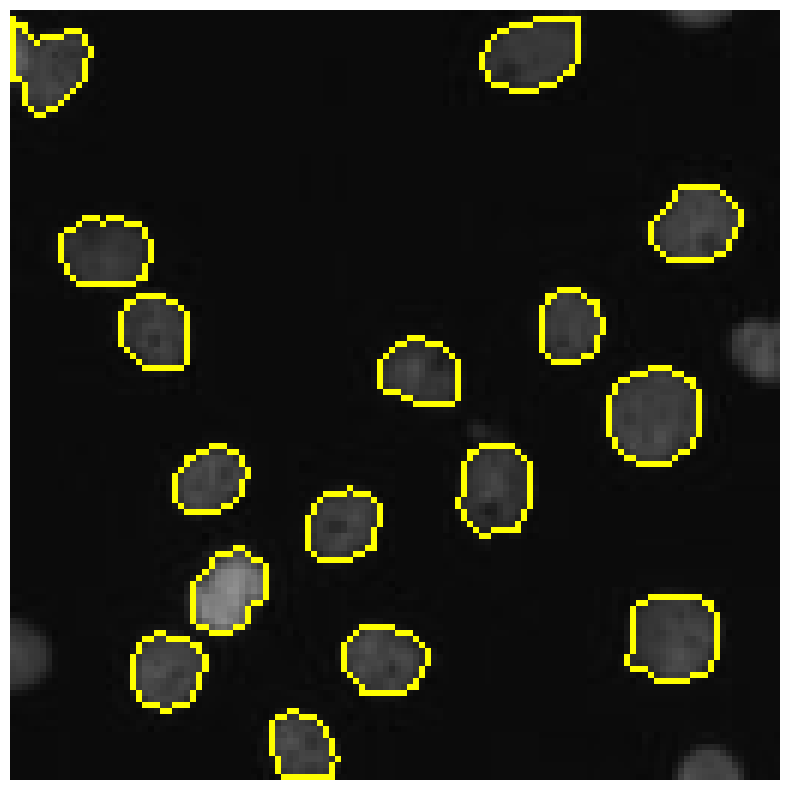

In [ ]:
display_image_with_overlay(image, masks, items=items)

# Chapter 4: Segment objects with Prompts


## Chapter 4.1: Points

In this chapter, we will learn about how to prompt SAM with coordinates of each object (points) and let it create the segmentation around that object. This is especially useful when we know the locations of the objects, or we want to simply click on the objects we want to segment and create precise segmentation.

Let us first identify the location of a cell in the image below.

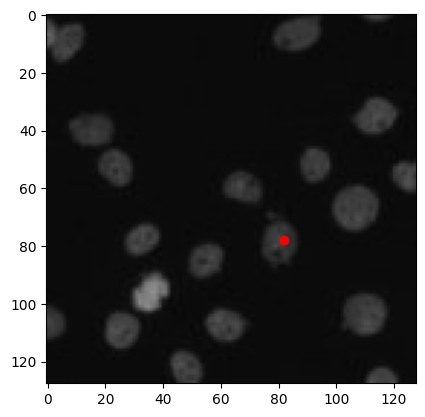

In [ ]:
# Display the image and get some points for some of the objects
plt.imshow(image, cmap='gray')
plt.scatter(82, 78, color='red')

In [ ]:
# Load the image into SAM
predictor = SamPredictor(sam)
predictor.set_image(image)

In [ ]:
# Create segmentation for the object at the location
input_point = np.array([[82,78]])
input_label = np.array([1]) #1: foreground, 0:background

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

Above, we can provide multiple different points as input and also whether they are foreground or background. The parameter `multimask_output` is set to `True` which by deafult returns 3 outputs with IoU scores. We can modify the function to get more than 3 outputs. However, we will soon see that in most cases we will not need more than 3 outputs.

(-0.5, 127.5, 127.5, -0.5)

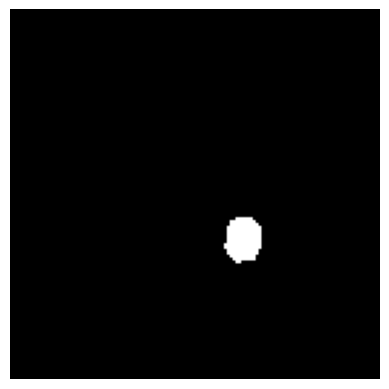

In [ ]:
plt.imshow(masks[0], cmap='gray')
plt.axis('off')

In [ ]:
# Display individual masks and IoU scores
def display_image_with_individual_overlay(image, masks, scores):
  if len(masks)==3:
    plt.figure(figsize=(18,6))
    for i, mask in enumerate(masks):
      img = np.copy(image)

      contours, _ = cv.findContours(mask.astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
      cv.drawContours(img, contours, -1, color=[255, 255, 0], thickness=1)

      plt.subplot(1,3,i+1)
      plt.imshow(img)
      plt.title('Score: {:.4f}'.format(scores[i]))
      plt.axis('off')

  else:
    plt.figure(figsize=(10,10))

    img = np.copy(image)

    contours, _ = cv.findContours(masks.astype('uint8'), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(img, contours, -1, color=[255, 255, 0], thickness=1)

    plt.imshow(img)
    plt.title('Score: {:.4f}'.format(scores))
    plt.axis('off')

In [ ]:
# Run the object detection again but with multimask False

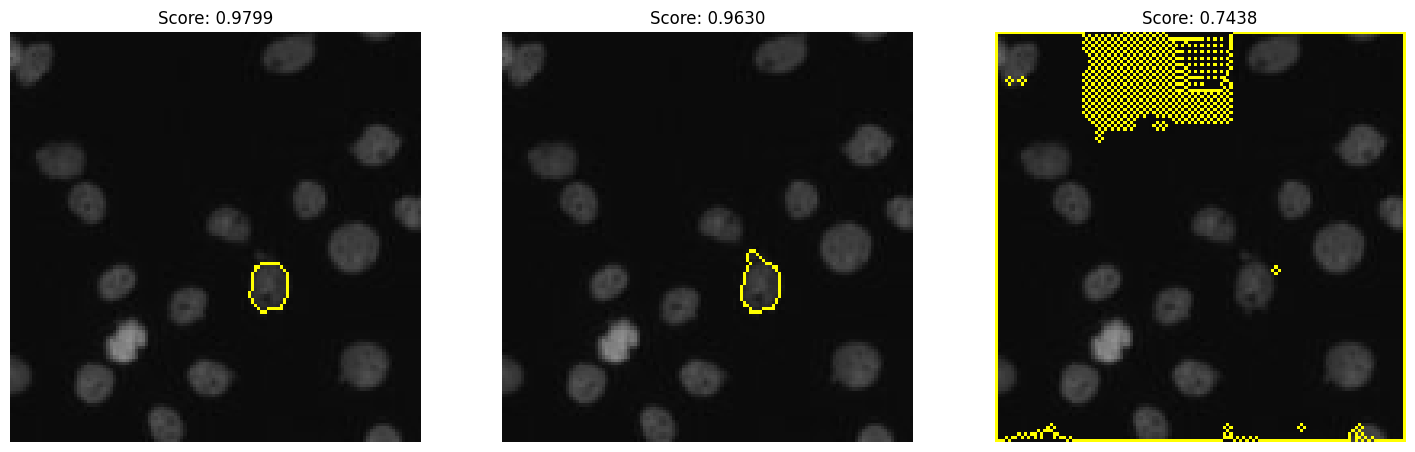

In [ ]:
# Display indiidual masks and IoU scores associated
display_image_with_individual_overlay(image, masks, scores)

Similarly, we can set the `multimask_output` to `False` which will result in only a single output mask. Please note that it does not by default gives the mask with highest score, instead it somehow averages them to predict the final output.

In [ ]:
input_point = np.array([[82,78]])
input_label = np.array([1]) #1: foreground, 0:background

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [ ]:
len(masks)

1

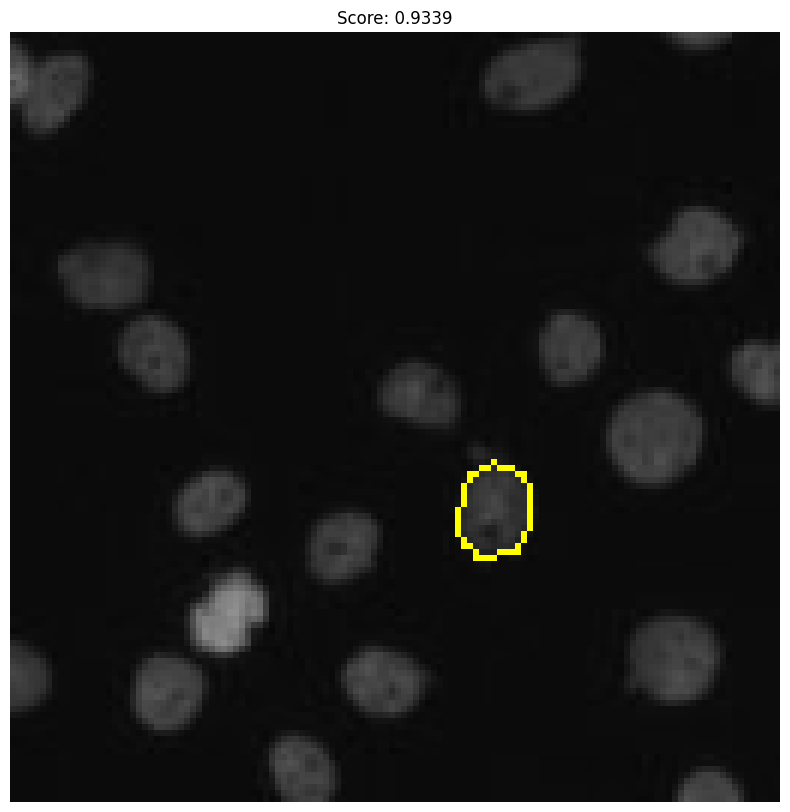

In [ ]:
display_image_with_individual_overlay(image, masks[0], scores[0])

## Chapter 4.2: Bounding Boxes

Now we would try the same with bounding boxes. Instead of points, we can also have bounding boxes as prompts to SAM.

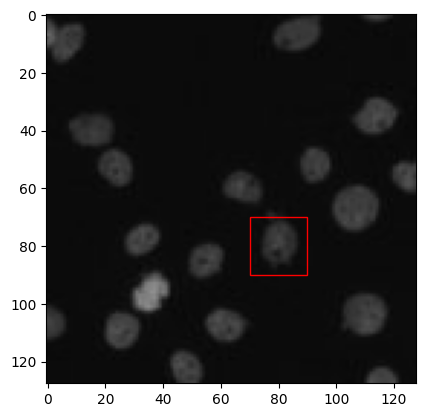

In [ ]:
# Draw bounding box aorund an object
fig, ax = plt.subplots()
ax.imshow(image)
ax.add_patch(plt.Rectangle((70,70), 20, 20, color='red', fill=False))

In [ ]:
# Generate multiple masks
input_box = np.array([70,70,90,90])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=True,
)

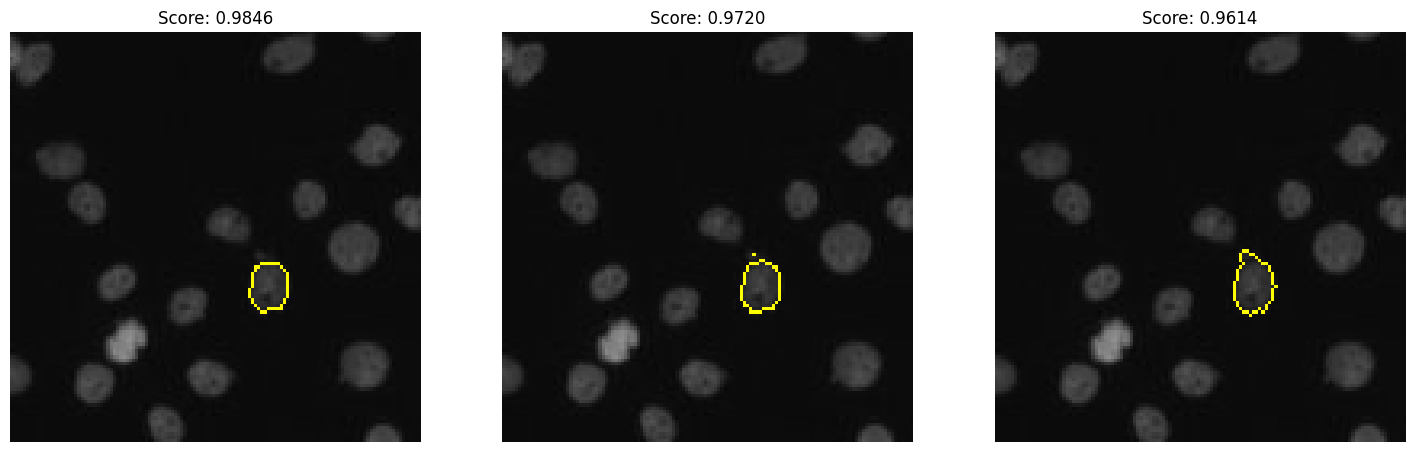

In [ ]:
# Display indiidual masks and IoU scores associated
display_image_with_individual_overlay(image, masks, scores)

In [ ]:
# Generate a single masks
input_box = np.array([70,70,90,90])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

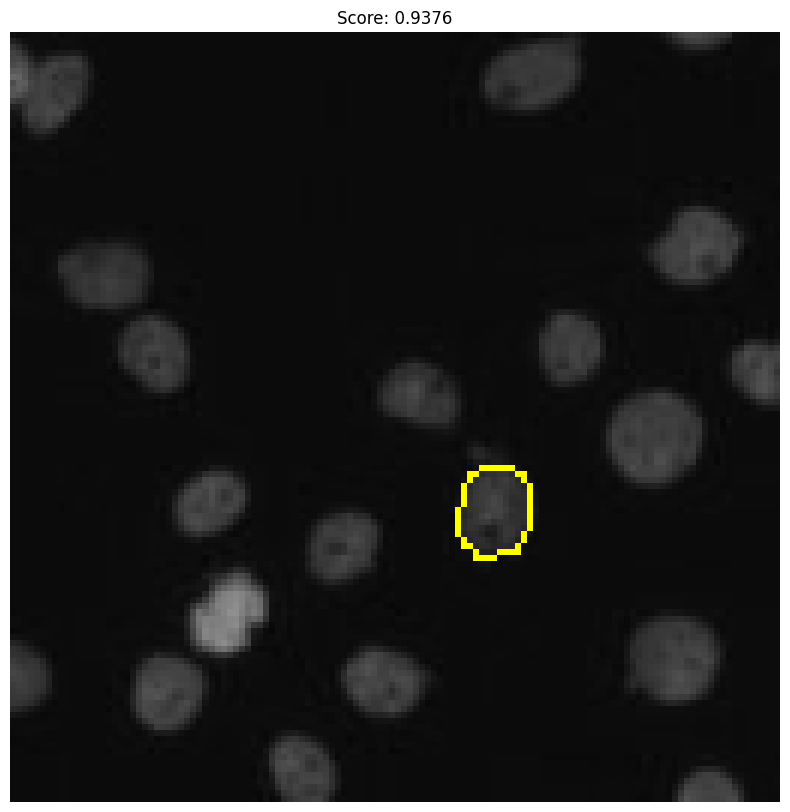

In [ ]:
# Display indiidual masks and IoU scores associated
display_image_with_individual_overlay(image, masks[0], scores[0])

# Chapter 5: Few other examples



### Antoine - Cells

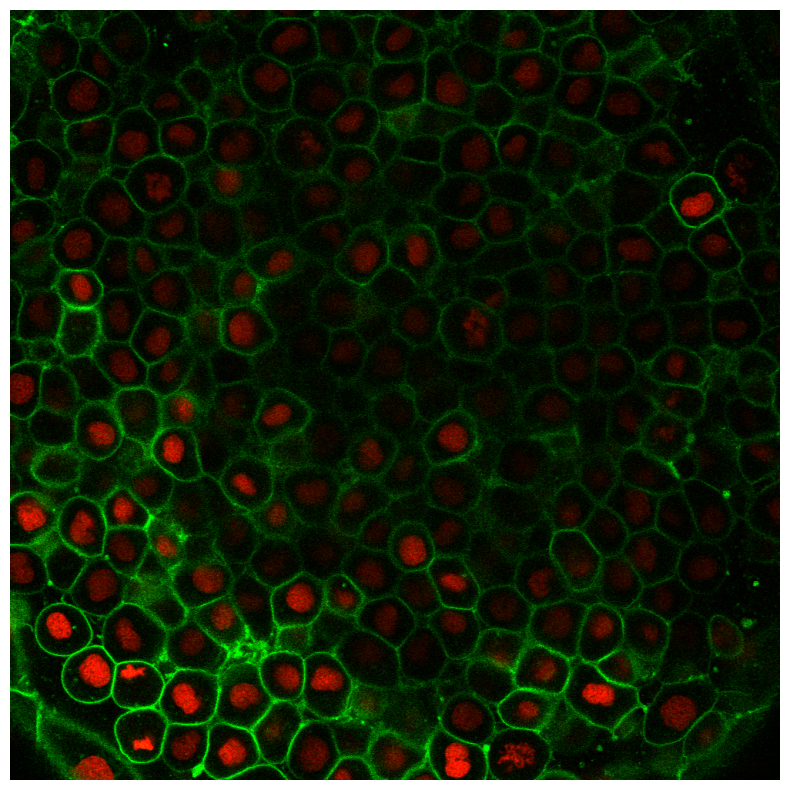

In [ ]:
# Load an image
image_path = '/content/drive/MyDrive/SAMWorkshop/images'
image_name = '2.png'
image = cv.imread(f'{image_path}/{image_name}')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

display_image(image)

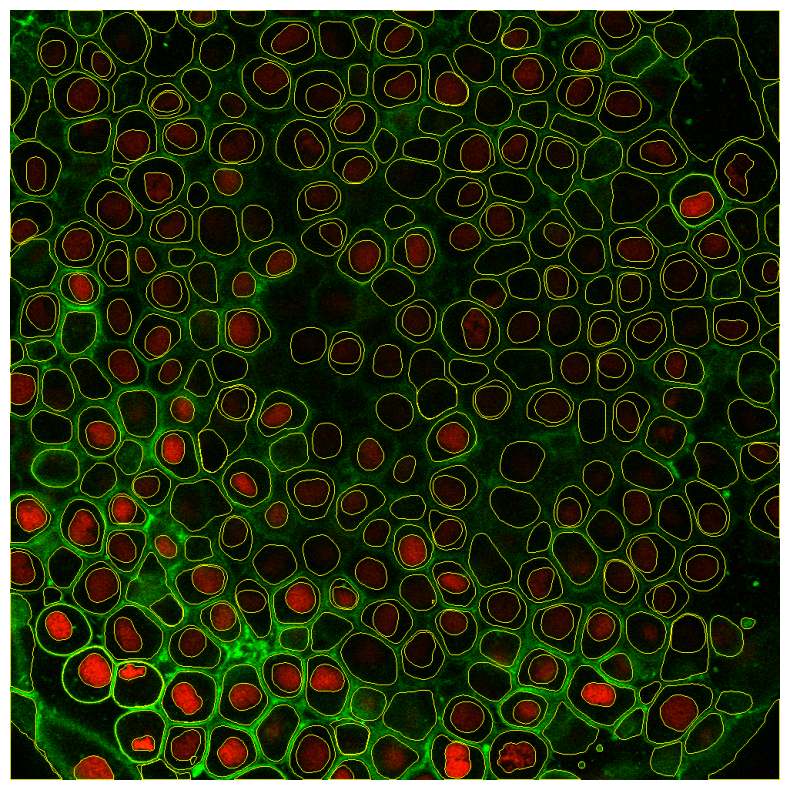

In [ ]:
# Load SAM model
sam_checkpoint = "/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# Generate mask
masks = mask_generator.generate(image)

# Display results
display_image_with_overlay(image, masks)

### NoRI

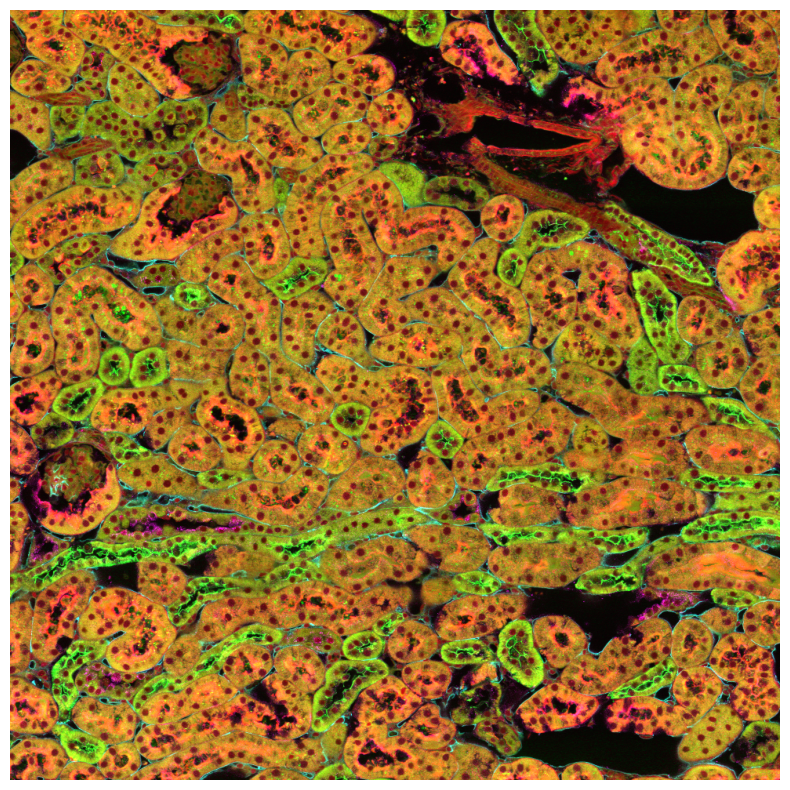

In [ ]:
# Load an image
image_path = '/content/drive/MyDrive/SAMWorkshop/images'
image_name = '3.png'
image = cv.imread(f'{image_path}/{image_name}')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

display_image(image)

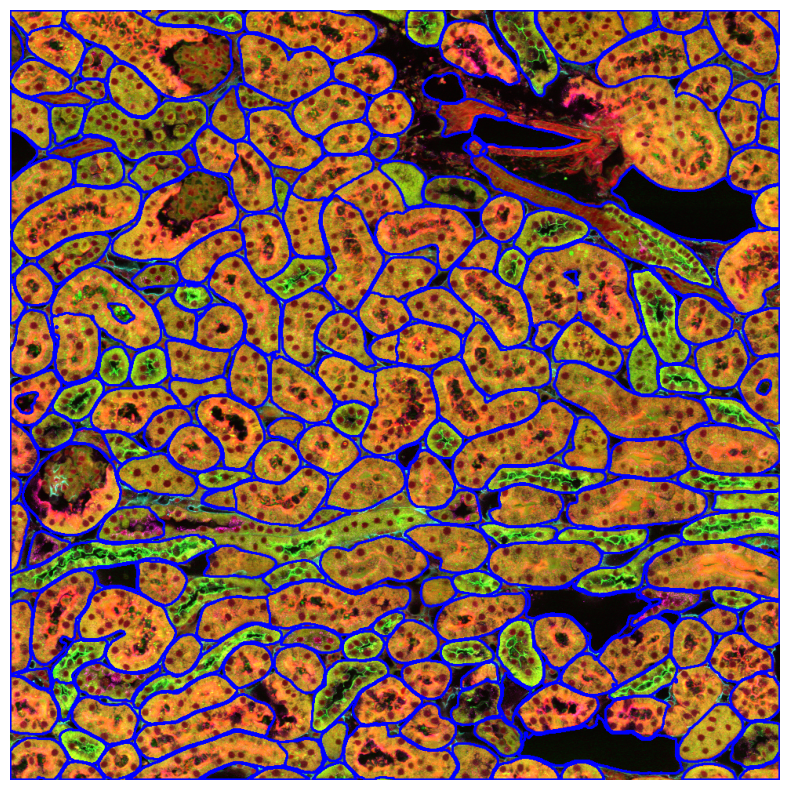

In [ ]:
# Load SAM model
sam_checkpoint = "/content/drive/MyDrive/SAMWorkshop/ModelCheckpoints/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, box_nms_thresh=0.3)

# Generate mask
masks = mask_generator.generate(image)

# Display results
display_image_with_overlay(image, masks, color=[0,0,255], thickness=2)

# Chapter 6: Conclusion

# APPENDIX:

## References

[1] Bommasani, R., Hudson, D.A., Adeli, E., Altman, R., Arora, S., von Arx, S., Bernstein, M.S., Bohg, J., Bosselut, A., Brunskill, E. and Brynjolfsson, E., 2021. On the opportunities and risks of foundation models. arXiv preprint arXiv:2108.07258. *(https://arxiv.org/abs/2108.07258)*


[2] Kirillov, A., Mintun, E., Ravi, N., Mao, H., Rolland, C., Gustafson, L., Xiao, T., Whitehead, S., Berg, A.C., Lo, W.Y. and Dollár, P., 2023. Segment anything. arXiv preprint arXiv:2304.02643. *(https://arxiv.org/abs/2304.02643)*


[3] Ma, J., He, Y., Li, F., Han, L., You, C. and Wang, B., 2024. Segment anything in medical images. Nature Communications, 15(1), p.654. *(https://www.nature.com/articles/s41467-024-44824-z)*

[4] Archit, A., Nair, S., Khalid, N., Hilt, P., Rajashekar, V., Freitag, M., Gupta, S., Dengel, A., Ahmed, S. and Pape, C., 2023. Segment anything for microscopy. bioRxiv, pp.2023-08. *(https://www.biorxiv.org/content/10.1101/2023.08.21.554208v1)*

[5] Israel, U., Marks, M., Dilip, R., Li, Q., Schwartz, M.S., Pradhan, E., Pao, E., Li, S., Pearson-Goulart, A., Perona, P. and Gkioxari, G., 2023. A Foundation Model for Cell Segmentation. bioRxiv, pp.2023-11. *(https://arxiv.org/abs/2311.11004)*

[6] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929. *(https://arxiv.org/abs/2010.11929)*

[7] He, K., Chen, X., Xie, S., Li, Y., Dollár, P. and Girshick, R., 2022. Masked autoencoders are scalable vision learners. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 16000-16009). *(https://arxiv.org/abs/2111.06377)*

[8] Tancik, M., Srinivasan, P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. and Ng, R., 2020. Fourier features let networks learn high frequency functions in low dimensional domains. Advances in Neural Information Processing Systems, 33, pp.7537-7547. *(https://arxiv.org/abs/2006.10739)*

[9] Radford, A., Kim, J.W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J. and Krueger, G., 2021, July. Learning transferable visual models from natural language supervision. In International conference on machine learning (pp. 8748-8763). PMLR. *(https://arxiv.org/abs/2103.00020)*

[10] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A.N., Kaiser, Ł. and Polosukhin, I., 2017. Attention is all you need. Advances in neural information processing systems, 30. *(https://arxiv.org/abs/1706.03762)*

## Questions:

* **Can you change the number of multimask output?** - Yes! In the mask_decoder it is defined as 3 which can changed by editing the code.


## Further reading:

**Can SAM Segment Anything? When SAM Meets Camouflaged Object Detection** \\
https://arxiv.org/abs/2304.04709

\\
**SAM-Adapter: Adapting Segment Anything in Underperformed Scenes** \\
https://openaccess.thecvf.com/content/ICCV2023W/VCL/html/Chen_SAM-Adapter_Adapting_Segment_Anything_in_Underperformed_Scenes_ICCVW_2023_paper.html

\\
**Segment Anything Model (SAM) for Digital Pathology: Assess Zero-shot Segmentation on Whole Slide Imaging** \\
https://arxiv.org/abs/2304.04155

\\
**Medical SAM Adapter: Adapting Segment Anything Model for Medical Image Segmentation** \\
https://arxiv.org/abs/2304.12620

\\
**When Foundation Model Meets Federated Learning: Motivations, Challenges, and Future Directions** \\
https://arxiv.org/abs/2306.15546

\\
**Segment Anything for Microscopy** \\
https://www.biorxiv.org/content/10.1101/2023.08.21.554208v1

\\
**Segment Anything – A Foundation Model for Image Segmentation** \\
https://learnopencv.com/segment-anything/

\\
**A Comprehensive Survey on Segment Anything Model for Vision and Beyond** \\
https://github.com/liliu-avril/Awesome-Segment-Anything#paper-list

\\
**Segment Anything Model with 🤗Transformers** - Tensorflow \\
https://keras.io/examples/vision/sam/

\\
**Unraveling the Segment Anything Model (SAM)** \\
https://appsilon.com/segment-anything-model-computer-vision/

\\
**Transformers in Vision: A Survey** \\
https://arxiv.org/pdf/2101.01169.pdf

\\
**Meta AI's New Breakthrough: Segment Anything Model (SAM) Explained** \\
https://encord.com/blog/segment-anything-model-explained/
